In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import numpy as np 
import pandas as pd

dataset = pd.read_csv("combined_data.csv")

In [3]:
# Extract out sentences and labels
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Print some example sentences and labels
for x in range(2):
  print(sentences[x])
  print(labels[x])
  print("\n")

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1




# Create a subwords dataset

In [4]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

# How big is the vocab size?
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


In [6]:
# Replace sentence data with encoded subwords

for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

# Check the sentences are appropriately replaced
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [7]:
# Final pre-processing
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Create the model using an Embedding

In [8]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [9]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))


Epoch 1/30
50/50 [==============================] - 1s 7ms/step - loss: 0.6932 - accuracy: 0.5129 - val_loss: 0.6943 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5430 - val_loss: 0.6927 - val_accuracy: 0.4787
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.6604 - val_loss: 0.6892 - val_accuracy: 0.5940
Epoch 4/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.7495 - val_loss: 0.6794 - val_accuracy: 0.7343
Epoch 5/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.7564 - val_loss: 0.6688 - val_accuracy: 0.7594
Epoch 6/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.7979 - val_loss: 0.6490 - val_accuracy: 0.7694
Epoch 7/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.7985 - val_loss: 0.6193 - val_accuracy: 0.7669
Epoch 8/30
50/50 [==

# Plot the accuracy and loss

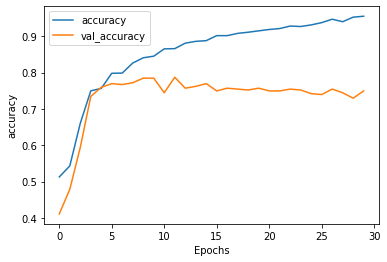

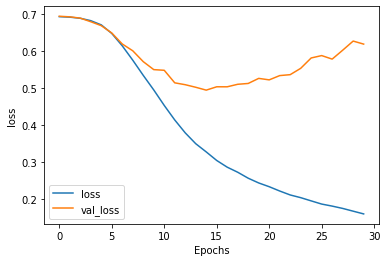

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


# Define a function to predict the sentiment of reviews

In [11]:
# Define a function to take a series of reviews
# and predict whether each one is a positive or negative review

# max_length = 100 # previously defined

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [22]:
# Use the model to predict some reviews   
# fake_reviews = ["I love this phone", 
#                 "Everything was cold",
#                 "Everything was hot exactly as I wanted", 
#                 "Everything was green", 
#                 "the host seated us immediately",
#                 "they gave us free chocolate cake", 
#                 "we couldn't hear each other talk because of the shouting in the kitchen"
#               ]
fake_reviews = [
    "Not worthy the money",
    "Best budget watch",
    "Good budget smart watch with alexa",
    "Everythig is perfect except battery",
    "Reliable product",
    "Stylish watch"
]
predict_review(model, fake_reviews)


1/1 [==============================] - 0s 31ms/step
[385 691  10   1 395   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Not worthy the money
[0.00546931]


[493 228 105 843 175 171 641   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Best budget watch
[0.70639765]


[625 105 843 175 309  58   8 171 641 775  23 180 333 840   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Good budget smart watch with alexa
[0.9130568]


[812 227 864 505 102   7 652 153 333  51 703 775 225 857 864   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everythig is p

In [13]:
def fit_model_now (model, sentences) :
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, 
                      validation_data=(testing_sequences, testing_labels_final))
  return history

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def fit_model_and_show_results (model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

# Add a bidirectional LSTM

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 6)                 198       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 8s 50ms/step - loss: 0.6897 - accuracy: 0.5242 - val_loss: 0.706

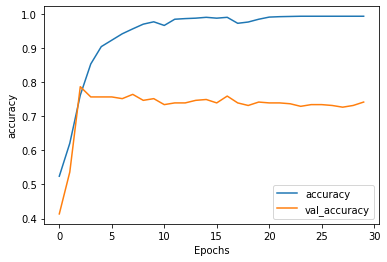

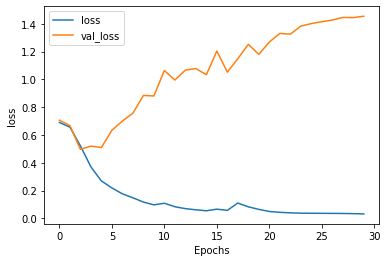

1/1 [==============================] - 1s 856ms/step
[385 691  10   1 395   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Not worthy the money
[0.00839437]


[493 228 105 843 175 171 641   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Best budget watch
[0.22341965]


[625 105 843 175 309  58   8 171 641 775  23 180 333 840   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Good budget smart watch with alexa
[0.9994053]


[812 227 864 505 102   7 652 153 333  51 703 775 225 857 864   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everythig is 

In [24]:
# Define the model
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(6, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)

# Use multiple bidirectional layers

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_5 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 6)                 198       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 26,701
Trainable params: 26,701
Non-trai

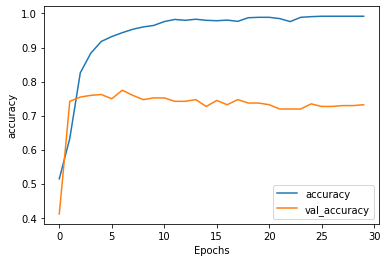

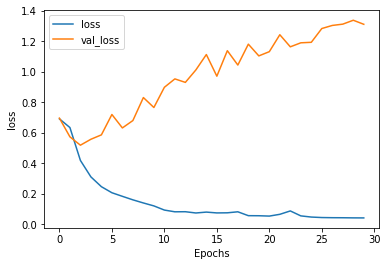

1/1 [==============================] - 2s 2s/step
[385 691  10   1 395   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Not worthy the money
[0.02193924]


[493 228 105 843 175 171 641   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Best budget watch
[0.01957849]


[625 105 843 175 309  58   8 171 641 775  23 180 333 840   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Good budget smart watch with alexa
[0.99866855]


[812 227 864 505 102   7 652 153 333  51 703 775 225 857 864   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everythig is pe

In [23]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

# Compare predictions for all the models

In [18]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [19]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
1/1 [==============================] - 0s 25ms/step
lovely
[0.9287092]


dreadful
[0.20284419]


stay away
[0.58296925]


everything was hot exactly as I wanted
[0.7693107]


everything was not exactly as I wanted
[0.5179549]


they gave us free chocolate cake
[0.6638564]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.01229362]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.673906]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.75429386]


that place does not have quality meals and it isn't a good place to go for dinner
[0.84501237]




In [20]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
1/1 [==============================] - 0s 47ms/step
lovely
[0.99924046]


dreadful
[0.00116935]


stay away
[0.00549171]


everything was hot exactly as I wanted
[0.99993193]


everything was not exactly as I wanted
[0.22833596]


they gave us free chocolate cake
[0.49225432]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.04682762]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.7443873]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.9999501]


that place does not have quality meals and it isn't a good place to go for dinner
[0.92003334]




In [21]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:
1/1 [==============================] - 0s 40ms/step
lovely
[0.9996734]


dreadful
[0.01510769]


stay away
[0.02022533]


everything was hot exactly as I wanted
[0.01797825]


everything was not exactly as I wanted
[0.0163006]


they gave us free chocolate cake
[0.94695306]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.01764807]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.0173374]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.01541255]


that place does not have quality meals and it isn't a good place to go for dinner
[0.0172113]


